In [1]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

DATA_PATH = "../preparation_data/data.json"
MODEL_PATH = "model.h5"
EPOCHS = 14
BATCH_SIZE = 32
PATIENCE = 5
Nb_Classes = 7


In [2]:
#Pour charger les données d'entrainement et de validation à partir du fichier data.json
# x l'entrée
# y la cible
def charger_data(data_path):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    return X, y




In [3]:
#Découper les données en 3, pour l'entrainnement, la validation et le test
def decouper_tain_validate(data_path, test_size=0.2, validation_size=0.2):

    # charger les données
    X, y = charger_data(data_path)

    #decoupage en 3 pour l'entrainnement, la validation et le test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test




In [4]:
# Pour créer un modele Séquentiel de Convovolution (CNN)
#  Le modèle se compose de trois blocs de convolution avec une couche de pool maximale dans chacun d'eux.
# Il y a une couche entièrement connectée avec 64 unités au-dessus qui est activée par une fonction 
# d'activation relu .
# Ce modèle n'a pas été réglé pour une grande précision tiré d'un tutoriel de classificatin standard

def creer_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
   
    model = tf.keras.models.Sequential()

    # 1ere couche de convolution
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2ème couche de convolution
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3ème couche de convolution
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    tf.keras.layers.Dropout(0.25)
    # couche dense de 64 unités 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.5)

    # Couche de sortie avec le nombre de labels à predire
    model.add(tf.keras.layers.Dense(Nb_Classes, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    model.summary()

    return model


In [5]:
# Pour entrainer le modele 
# epochs est le nombre d'iteration pour l'apprentissage
# batch_size est léchantillons par lot
# patience est le nombre d'itération à attendre avant de s'arrêter s'il n'y pas d'amélioration
# X_train, y_train, X_validation, y_validation sont respectivement les données d'apprentissage et de validation
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history




In [6]:
# Pour visualiser le taux de réussite/échec au fur de l'apprentisssage et de la validation
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="tarin_reussite")
    axs[0].plot(history.history['val_accuracy'], label="val_reussite")
    axs[0].set_ylabel("Reussite")
    axs[0].legend(loc="lower right")
    axs[0].set_title("evaluation réussite / perte")

    axs[1].plot(history.history["loss"], label="tarain_echec")
    axs[1].plot(history.history['val_loss'], label="val_echec")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Echec")
    axs[1].legend(loc="upper right")

    plt.show()


In [7]:
def main():
    
    # Découper les données en 3, pour l'entrainnement, la validation et le test
    X_train, y_train, X_validation, y_validation, X_test, y_test = decouper_tain_validate(DATA_PATH)

    # creation du modele
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = creer_model(input_shape)

    # entrainer le modèle
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

    # visualisation
    plot_history(history)

    # evaluation du modèle 
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # sauvegarder le modèle pour réutilisation
    model.save(MODEL_PATH)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 1, 32)          4

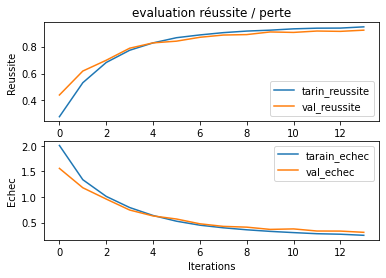

80/80 [==============================] - 1s 7ms/step - loss: 0.2835 - accuracy: 0.9285

Test loss: 0.2835419178009033, test accuracy: 92.84597635269165


In [8]:
if __name__ == "__main__":
    main()